## Lab 6: MNIST with CNN Model

Aryan Chauhan

In [32]:
#imports

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# check if cuda gpu is availible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")


device: cuda:0


## 1. Download the MNIST Dataset

In [33]:
# transforms for the training + test sets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# download training data
train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

# download test data
test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

print(f"training dataset size: {len(train_dataset)}")
print(f"test dataset size: {len(test_dataset)}")


training dataset size: 60000
test dataset size: 10000


# MNIST Dataset

MNIST is the standard dataset of values used for training/testing image processing systems to benchmark for classification algorithms to test CNN's

Dataset details:
- 70k images
   - 60k for training
   - 10k for testing
- 10 classes (0-9)
- 28x28 px images

In [34]:
# data loaders for batch processing
batch_size = 64

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False
)

print(f"batches in training loader: {len(train_loader)}")
print(f"batches in test loader: {len(test_loader)}")


batches in training loader: 938
batches in test loader: 157


# Data Preprocessing

First the images are converted from PIL images to PyTorch tensors with 'transforms.toTensor()'
scales from [0, 255] to [0, 1]

Next, the images are normalized using the mean '0.1307' and the standard deviation of '0.3081' of MNIST dataset.
Normalization centers the data around zero with the variance in mind.

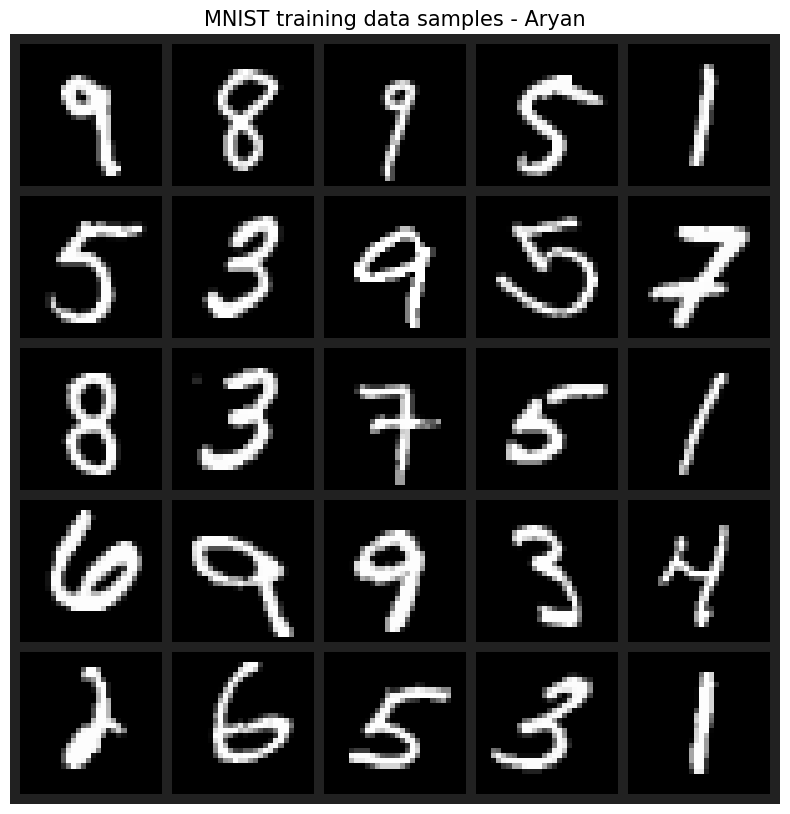

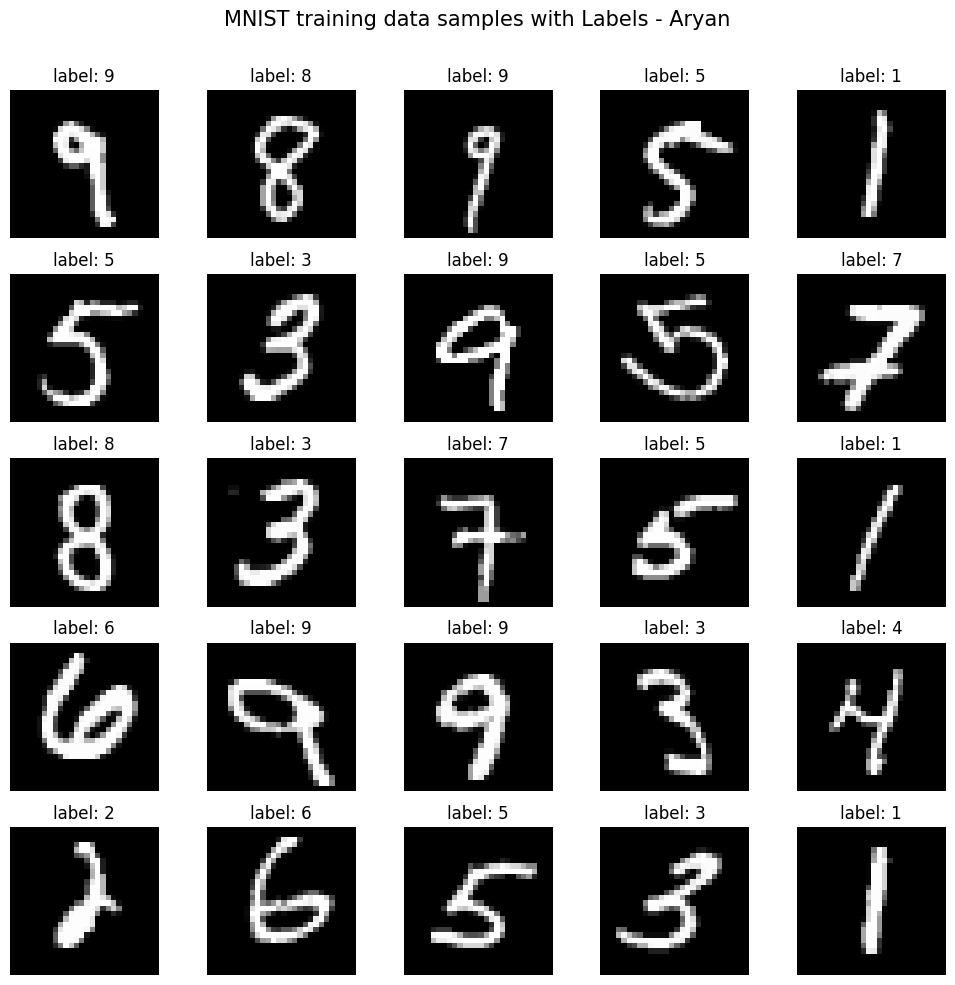

In [35]:
def visualize_dataset_samples(dataloader, title):
    # get batch of images
    images, labels = next(iter(dataloader))
    
    # make grid of images
    img_grid = torchvision.utils.make_grid(images[:25], nrow=5)
    
    # tensor to numpy array for plotting
    img_grid = img_grid.numpy().transpose((1, 2, 0))
    
    # denormalizemages for better visualization
    mean = 0.1307
    std = 0.3081
    img_grid = std * img_grid + mean
    img_grid = np.clip(img_grid, 0, 1)
    
    # plot
    plt.figure(figsize=(10, 10))
    plt.title(f"{title} - Aryan", fontsize=15)
    plt.imshow(img_grid, cmap='gray')
    plt.axis('off')
    plt.show()
    
    # label
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    fig.suptitle(f"{title} with Labels - Aryan", fontsize=15)
    
    for i, ax in enumerate(axes.flat):
        if i < 25:
            ax.imshow(images[i][0], cmap='gray')
            ax.set_title(f"label: {labels[i].item()}")
            ax.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# vidualize training data
visualize_dataset_samples(train_loader, "MNIST training data samples")


In [36]:
class MNISTConvNet(nn.Module):
    def __init__(self):
        super(MNISTConvNet, self).__init__()
        
        # 1st convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # 2nd convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # 3rd convolutional block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )
        
    def forward(self, x):
        # convolutional blocks
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        # fully connected layers application
        x = self.fc(x)
        return x

# make model and move it to the device
model = MNISTConvNet().to(device)


# CNN Model Architecture

The model is made of 3 convelution blocks with layers of increase filters, an ReLU activation function, batch normalization and downsampling.

The fully connected layers convert 3d feature maps to a 1d vector. layer 1 has 256 neurons + ReLU activation, a dropout layer set to 0.5 and, an output layer with 10 neurons.

In [37]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.1, 
    patience=5, 
    verbose=True
)


c:\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [38]:
# print model architecture
print(model)

# use torchsummary show summary of the CNN
summary(model, (1, 28, 28))


MNISTConvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1152, out_features=256

In [39]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=10):
    # list to store metrics to visualize
    train_losses = []
    test_losses = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        # training phase
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # 0 parameter gradients
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # back pass
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        # calc epoch loss
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # evaluation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * images.size(0)
                
                # calc accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # calc epoch metrics
        epoch_test_loss = running_loss / len(test_loader.dataset)
        epoch_accuracy = 100 * correct / total
        
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_accuracy)
        
        # update learning rate
        scheduler.step(epoch_test_loss)
        
        # print epoch stats
        print(f'epoch {epoch+1}/{num_epochs}, '
              f'train loss: {epoch_train_loss:.4f}, '
              f'test loss: {epoch_test_loss:.4f}, '
              f'test accuracy: {epoch_accuracy:.2f}%')
    
    return train_losses, test_losses, test_accuracies


In [40]:
# train model
num_epochs = 15
train_losses, test_losses, test_accuracies = train_model(
    model, 
    train_loader, 
    test_loader, 
    criterion, 
    optimizer, 
    scheduler, 
    num_epochs=num_epochs
)


epoch 1/15, train loss: 0.1134, test loss: 0.0318, test accuracy: 98.98%
epoch 2/15, train loss: 0.0495, test loss: 0.0345, test accuracy: 98.88%
epoch 3/15, train loss: 0.0396, test loss: 0.0236, test accuracy: 99.32%
epoch 4/15, train loss: 0.0320, test loss: 0.0253, test accuracy: 99.17%
epoch 5/15, train loss: 0.0274, test loss: 0.0231, test accuracy: 99.33%
epoch 6/15, train loss: 0.0246, test loss: 0.0380, test accuracy: 98.94%
epoch 7/15, train loss: 0.0240, test loss: 0.0256, test accuracy: 99.34%
epoch 8/15, train loss: 0.0211, test loss: 0.0286, test accuracy: 99.29%
epoch 9/15, train loss: 0.0169, test loss: 0.0424, test accuracy: 99.07%
epoch 10/15, train loss: 0.0197, test loss: 0.0314, test accuracy: 99.25%
epoch 11/15, train loss: 0.0159, test loss: 0.0288, test accuracy: 99.37%
epoch 12/15, train loss: 0.0069, test loss: 0.0285, test accuracy: 99.43%
epoch 13/15, train loss: 0.0038, test loss: 0.0279, test accuracy: 99.49%
epoch 14/15, train loss: 0.0029, test loss: 0.0

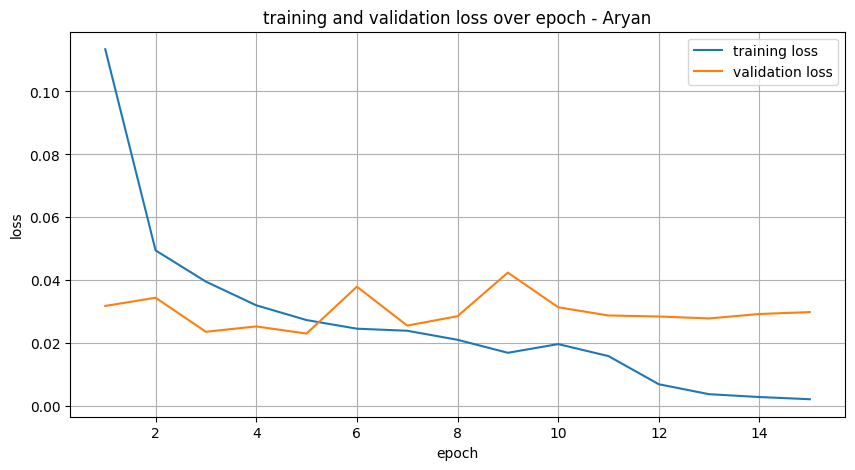

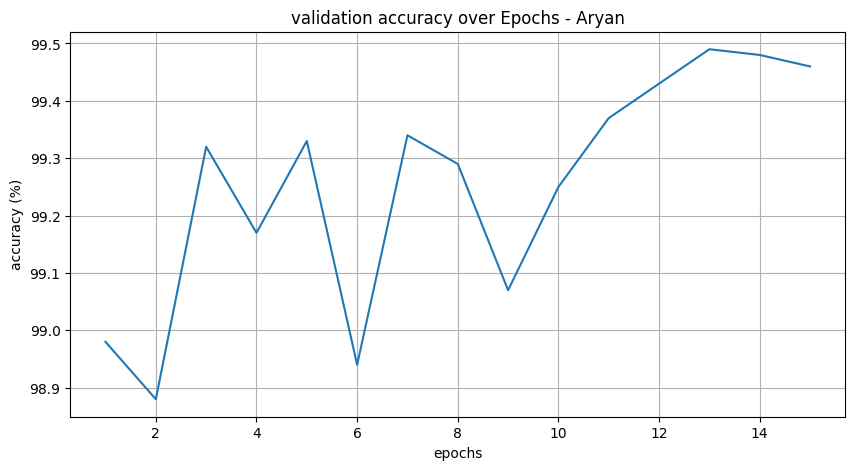

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='training loss')
plt.plot(range(1, num_epochs+1), test_losses, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('training and validation loss over epoch - Aryan')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), test_accuracies)
plt.xlabel('epochs')
plt.ylabel('accuracy (%)')
plt.title('validation accuracy over Epochs - Aryan')
plt.grid(True)
plt.show()



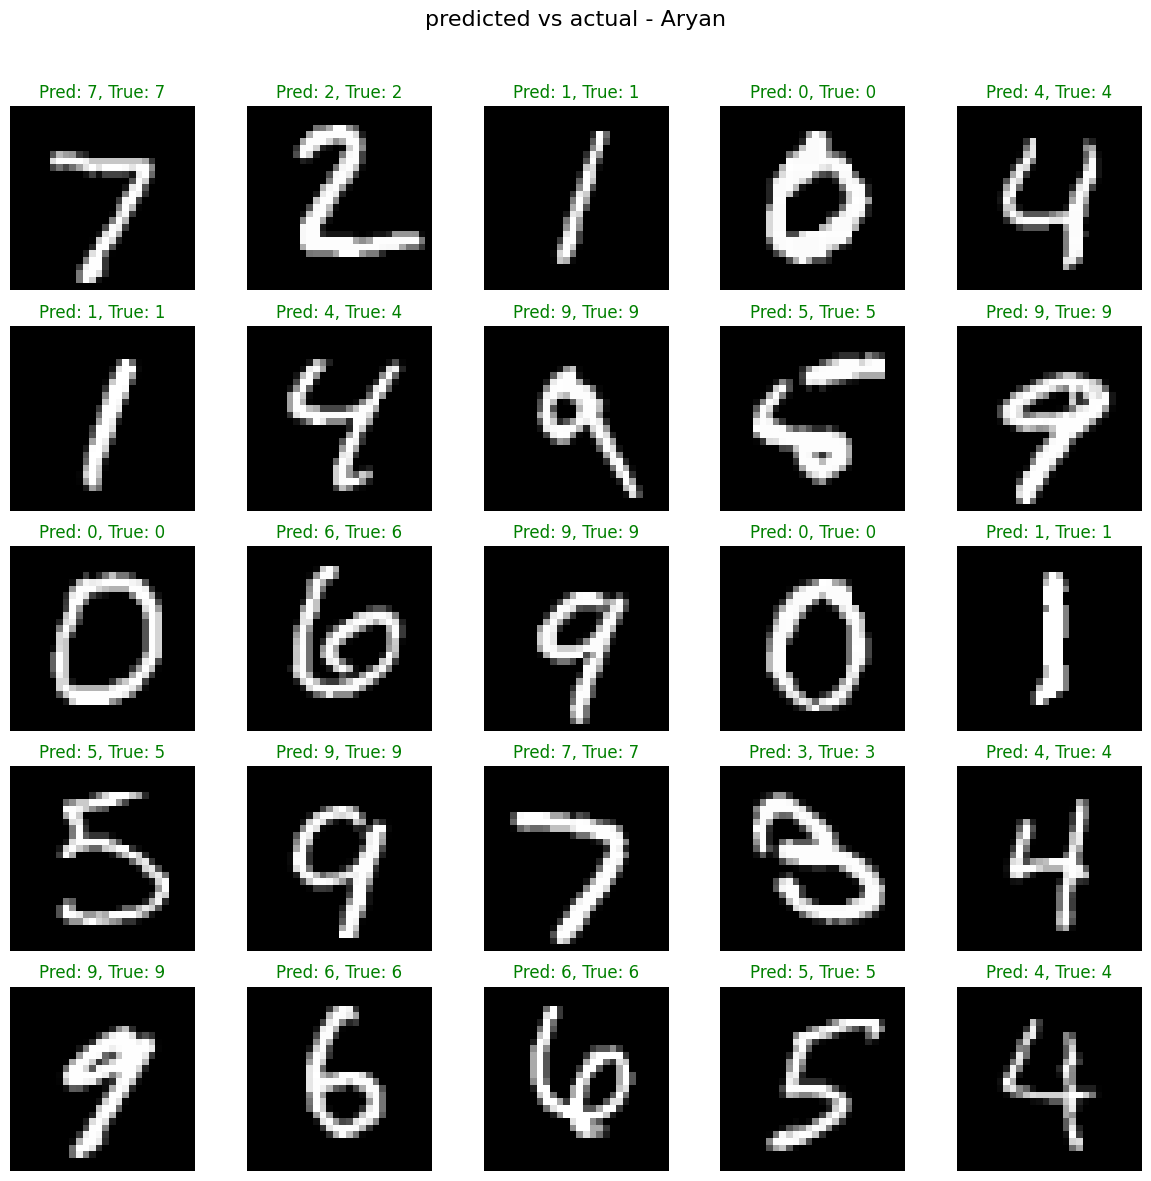

In [42]:
def visualize_predictions(model, test_loader, num_samples=25):
    # get a batch of test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    
    # move to device and get predictions
    images, labels = images.to(device), labels.to(device)
    
    # get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    # move to CPU for visualize
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()
    
    # plot the images w/ actual + predicted labels
    fig, axes = plt.subplots(5, 5, figsize=(12, 12))
    fig.suptitle('predicted vs actual - Aryan', fontsize=16)
    
    for i, ax in enumerate(axes.flat):
        if i < num_samples:
            ax.imshow(images[i][0], cmap='gray')
            color = 'green' if predicted[i] == labels[i] else 'red'
            ax.set_title(f'Pred: {predicted[i]}, True: {labels[i]}', color=color)
            ax.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

visualize_predictions(model, test_loader)


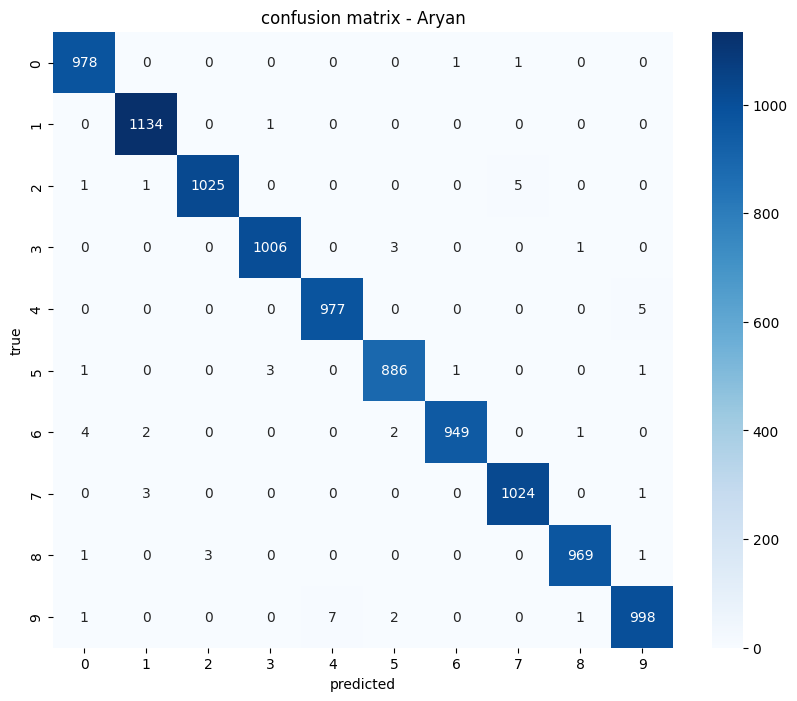

In [43]:
def plot_confusion_matrix(model, test_loader):
    # lists predictions/true labels
    all_preds = []
    all_labels = []
    
    # get predictions for entire test set
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # plot matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('predicted')
    plt.ylabel('true')
    plt.title('confusion matrix - Aryan')
    plt.show()
    
    return cm

cm = plot_confusion_matrix(model, test_loader)


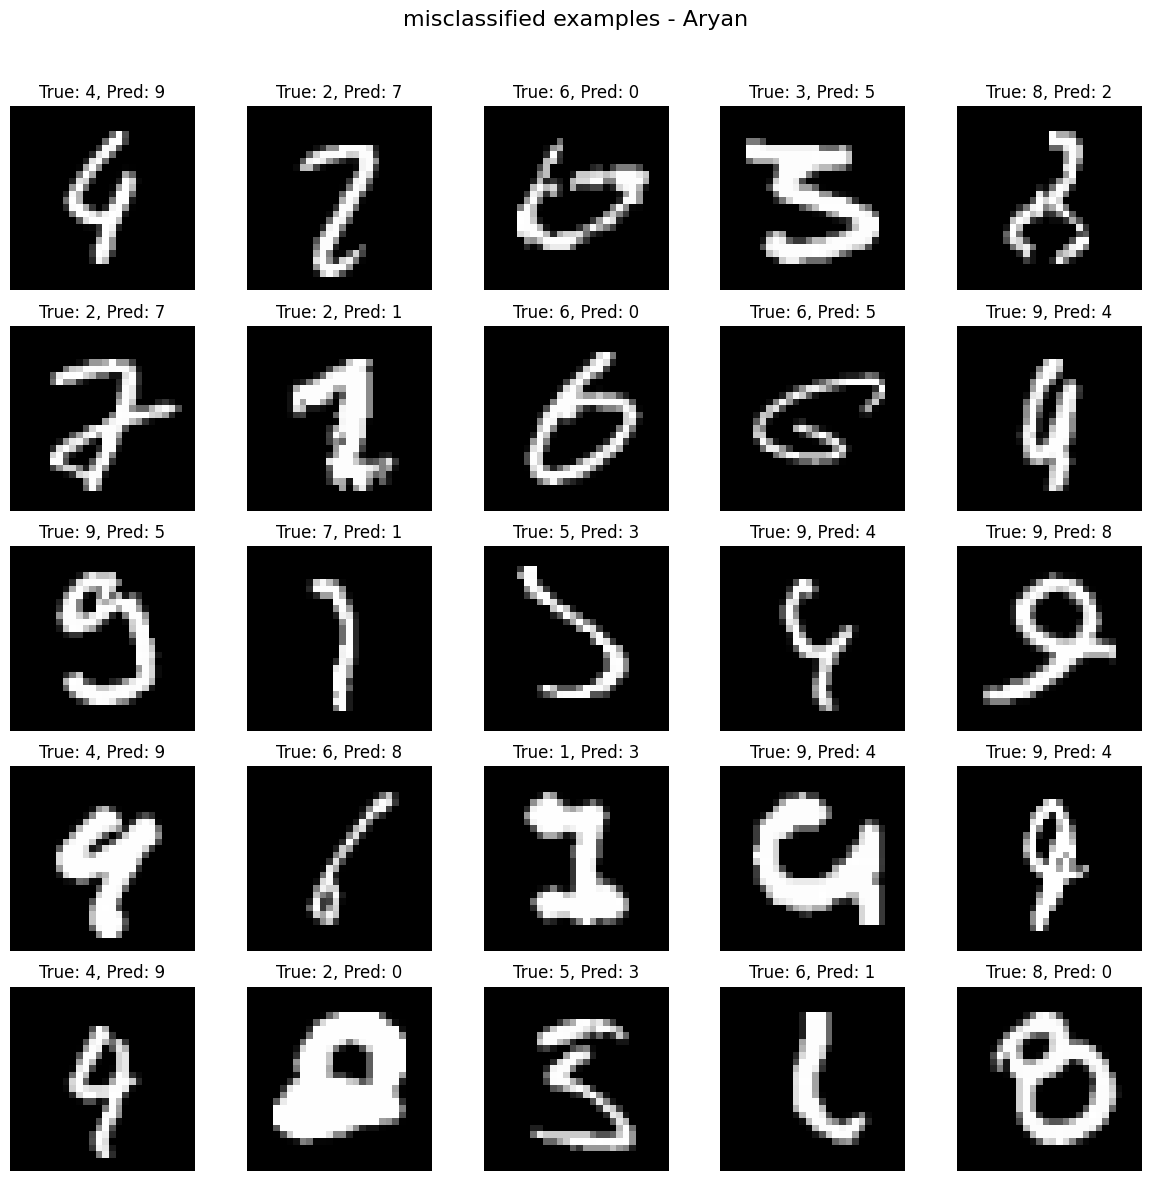

In [44]:
def visualize_misclassified(model, test_loader, num_samples=25):
    # list misclassified vals
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []
    
    # find misclassified vals
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # find misclassified vals in this batch
            mask = (predicted != labels)
            misclassified_images.extend(images[mask].cpu())
            misclassified_labels.extend(labels[mask].cpu().numpy())
            misclassified_preds.extend(predicted[mask].cpu().numpy())
            
            if len(misclassified_images) >= num_samples:
                break
    
    # check to see we have exactly num_samples
    misclassified_images = misclassified_images[:num_samples]
    misclassified_labels = misclassified_labels[:num_samples]
    misclassified_preds = misclassified_preds[:num_samples]
    
    # plot misclassified vals
    fig, axes = plt.subplots(5, 5, figsize=(12, 12))
    fig.suptitle('misclassified examples - Aryan', fontsize=16)
    
    for i, ax in enumerate(axes.flat):
        if i < len(misclassified_images):
            ax.imshow(misclassified_images[i][0], cmap='gray')
            ax.set_title(f'True: {misclassified_labels[i]}, Pred: {misclassified_preds[i]}')
            ax.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

visualize_misclassified(model, test_loader)


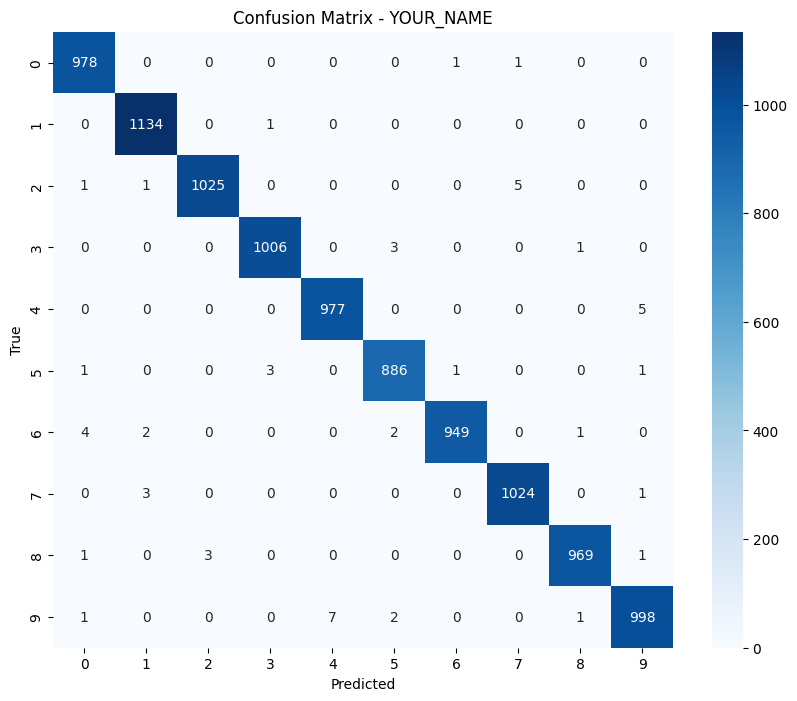

In [45]:
def plot_confusion_matrix(model, test_loader):
    # list stores predictions + true labels
    all_preds = []
    all_labels = []
    
    # get predictions for entire test set
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - YOUR_NAME')
    plt.show()
    
    return cm

cm = plot_confusion_matrix(model, test_loader)


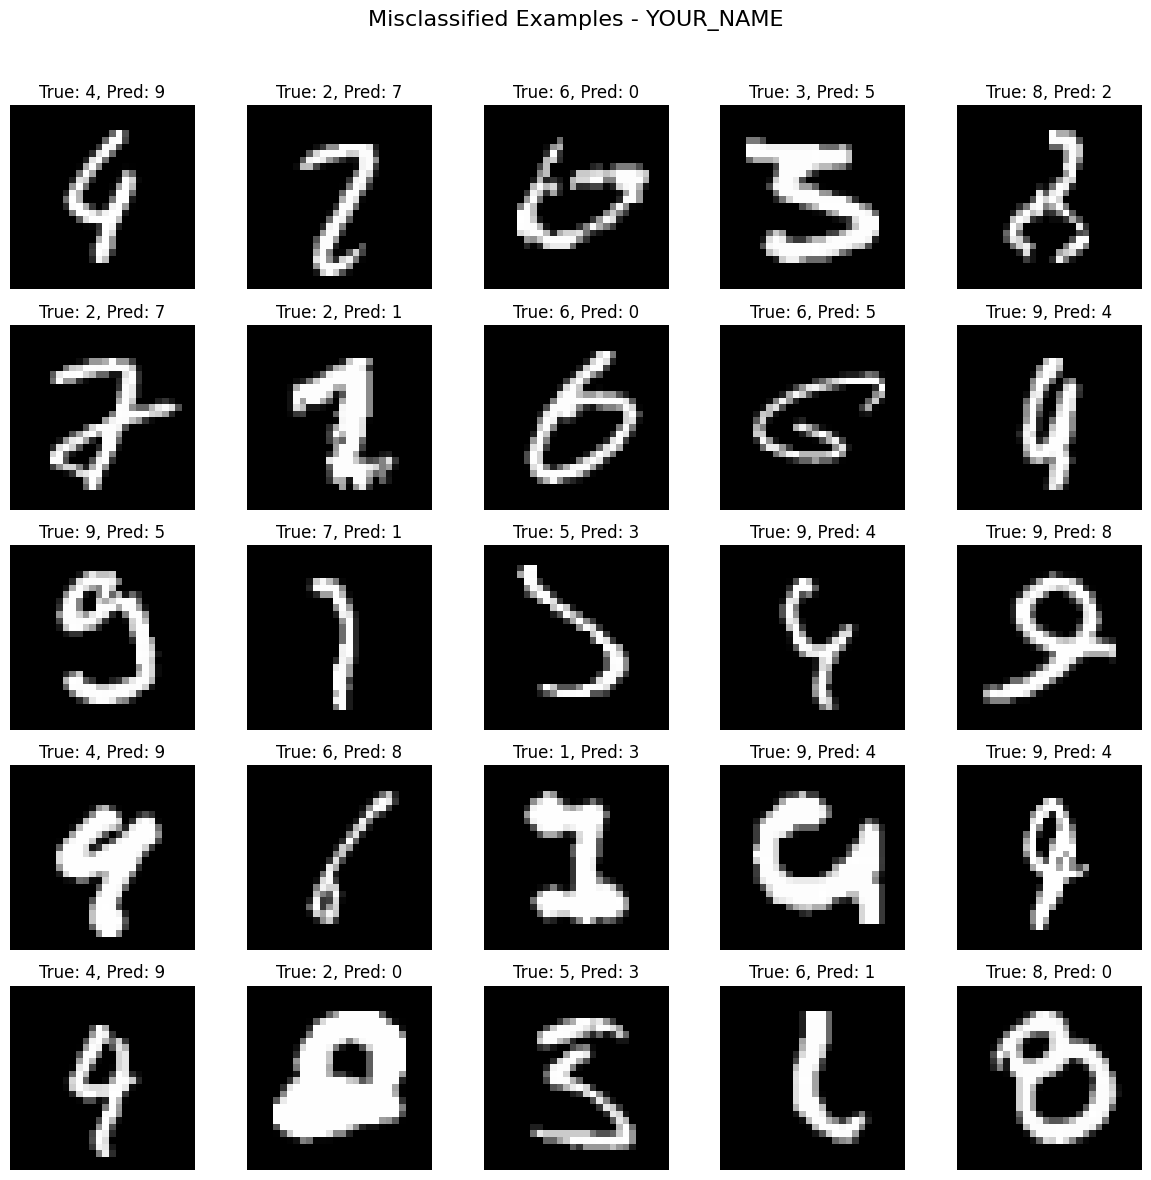

In [46]:
def visualize_misclassified(model, test_loader, num_samples=25):
    # list misclassified vals
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []
    
    # find misclassified vals
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # find misclassified vals in each batch
            mask = (predicted != labels)
            misclassified_images.extend(images[mask].cpu())
            misclassified_labels.extend(labels[mask].cpu().numpy())
            misclassified_preds.extend(predicted[mask].cpu().numpy())
            
            if len(misclassified_images) >= num_samples:
                break
    
    # make sure we have num_samples
    misclassified_images = misclassified_images[:num_samples]
    misclassified_labels = misclassified_labels[:num_samples]
    misclassified_preds = misclassified_preds[:num_samples]
    
    # plot
    fig, axes = plt.subplots(5, 5, figsize=(12, 12))
    fig.suptitle('Misclassified Examples - YOUR_NAME', fontsize=16)
    
    for i, ax in enumerate(axes.flat):
        if i < len(misclassified_images):
            ax.imshow(misclassified_images[i][0], cmap='gray')
            ax.set_title(f'True: {misclassified_labels[i]}, Pred: {misclassified_preds[i]}')
            ax.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

visualize_misclassified(model, test_loader)


In [47]:
# save the trained model
torch.save(model.state_dict(), 'mnist_model.pth')
print("model saved!")


model saved!


In [48]:
# show how to load the model
def load_model(model_path):
    # init a new model
    loaded_model = MNISTConvNet().to(device)
    
    # load state dictionary
    loaded_model.load_state_dict(torch.load(model_path))
    
    # set model to evaluation mode
    loaded_model.eval()
    
    return loaded_model

# load model
loaded_model = load_model('mnist_model.pth')

# verify loaded model works
# get batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# get predictions
with torch.no_grad():
    outputs = loaded_model(images)
    _, predicted = torch.max(outputs, 1)

# calc accuracy for this batch
correct = (predicted == labels).sum().item()
total = labels.size(0)
print(f"loaded model accuracy on a test batch: {100 * correct / total:.2f}%")


loaded model accuracy on a test batch: 100.00%
